In [1]:
!pip install wandb

In [2]:
!wandb login 

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import pandas as pd
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


# 코드 다시 돌리기 위한 seed 고정
import random
import numpy as np
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
CFG = {'RUN_NAME':'CIFAR_100_128',
       'DROPOUT':0.2,
       'EPOCHS':100,
       'LR': 0.001,
       'N_CHANNELS': 128,
      }

In [5]:
#성능 개선을 위해 wandb 사용
import wandb
wandb.init(project="Tobigs", entity=)
wandb.config=CFG
wandb.run.name = CFG['RUN_NAME']

wandb: Currently logged in as: mintyprotein. Use `wandb login --relogin` to force relogin


In [8]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        self.conv0 = nn.Sequential(nn.Conv2d(3, CFG['N_CHANNELS'], 3, 1, 'same'),
                                   nn.BatchNorm2d(CFG['N_CHANNELS']),
                                   nn.ReLU(),
                                   nn.Dropout(CFG['DROPOUT']),
                                  )
        self.conv1 = nn.Sequential(nn.Conv2d(CFG['N_CHANNELS'], CFG['N_CHANNELS']*2, 3, 1, 'same'),
                                   nn.BatchNorm2d(CFG['N_CHANNELS']*2),
                                   nn.ReLU(),
                                   nn.Dropout(CFG['DROPOUT']),
                                   nn.MaxPool2d(2,2)
                                  )
        self.conv2 = nn.Sequential(nn.Conv2d(CFG['N_CHANNELS']*2, CFG['N_CHANNELS']*4, 3, 1, 'same'),
                                   nn.BatchNorm2d(CFG['N_CHANNELS']*4),
                                   nn.ReLU(),
                                   nn.Dropout(CFG['DROPOUT']),
                                   nn.MaxPool2d(2,2)
                                  )
        self.conv3 = nn.Sequential(nn.Conv2d(CFG['N_CHANNELS']*4, CFG['N_CHANNELS']*4, 3, 1, 'same'),
                                   nn.BatchNorm2d(CFG['N_CHANNELS']*4),
                                   nn.ReLU(),
                                   nn.Dropout(CFG['DROPOUT']),
                                  )
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(64 * CFG['N_CHANNELS'] * 4, num_classes)
                               )
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x        

In [9]:
model = MyModel(100).to(device)

In [10]:
#Torchvision의 RandomHorizontalFlip, RandomResizedCrop Augmentation 사용,
train_transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(32,32), scale=(0.9,1.0)),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])        

#Test성능 향상을 위해 TTA(Test-Time-Augmentation) 사용
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])    
tta = transforms.RandomHorizontalFlip(p=1)

train = torchvision.datasets.CIFAR100(root="./", train=True, download=True, transform=train_transform)
test = torchvision.datasets.CIFAR100(root="./", train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=256,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=256,
                                          shuffle=False, num_workers=2)

optimizer = optim.AdamW(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, verbose=True)

#라벨 스무딩 적용
criterion = nn.CrossEntropyLoss(label_smoothing =0.2)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


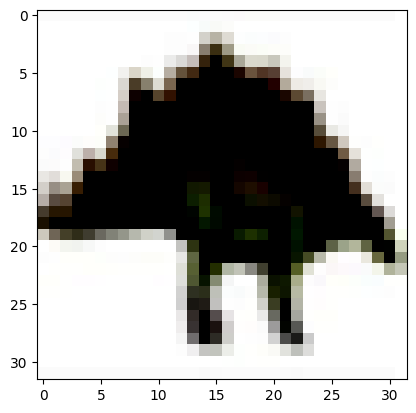

In [11]:
import matplotlib.pyplot as plt
plt.imshow(train[1][0].numpy().transpose(1,2,0))

In [ ]:
for epoch in range(100):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    best_acc = 0.0
    best_model_wts = model.state_dict()
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    correct, all_data = 0,0
    
    model.eval()
    for img, label in test_loader:
        with torch.no_grad():
            tta_img = tta(img).to(device)
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            tta_output = model(tta_img)
            #Original image와 flipped image를 독립적으로 predict 후, 평균값으로 각 클래스의 확률 결정
            output = (output + tta_output) / 2
            
            loss = criterion(output, label)
            running_val_loss += loss.item()
            
            correct += torch.sum(torch.argmax(output, dim=1) == label).item()
            all_data += len(label)
    if epoch % 2 == 0:        
        print(f"[EPOCH:{epoch+1}/{CFG['EPOCHS']}] [train_loss:{running_loss / len(train_loader)}] [Val_loss:{(running_val_loss / len(test_loader))}]  [val_acc:{correct / all_data}] ")
    #wandb 데이터 전송
    wandb.log({'Train_loss':running_loss / len(train_loader),
               'Val_loss': (running_val_loss / all_data),
               'Val_acc': (correct / all_data),
              })
    if correct / all_data > best_acc:
      best_acc = correct / all_data
      best_model_wts = model.state_dict()
    
    scheduler.step(correct / all_data)

100%|██████████| 196/196 [00:22<00:00,  8.81it/s]


[EPOCH:1/100] [train_loss:14.447573841834554] [Val_loss:4.5961641550064085]  [val_acc:0.0122] 


100%|██████████| 196/196 [00:19<00:00, 10.01it/s]


[EPOCH:3/100] [train_loss:4.235062088285174] [Val_loss:4.071077334880829]  [val_acc:0.1464] 


100%|██████████| 196/196 [00:19<00:00,  9.96it/s]


[EPOCH:5/100] [train_loss:3.9074087215929616] [Val_loss:3.8775642216205597]  [val_acc:0.2142] 


100%|██████████| 196/196 [00:19<00:00,  9.92it/s]


[EPOCH:7/100] [train_loss:3.727227973694704] [Val_loss:3.737323409318924]  [val_acc:0.2534] 


100%|██████████| 196/196 [00:19<00:00,  9.90it/s]


[EPOCH:9/100] [train_loss:3.576732418975052] [Val_loss:3.537054938077927]  [val_acc:0.3096] 


100%|██████████| 196/196 [00:19<00:00,  9.91it/s]


In [14]:
print(best_acc)

0.6087


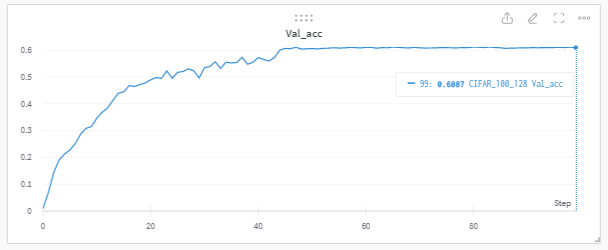

In [15]:
from IPython.display import Image
Image('./Val_acc.png')